In [2]:
#import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta  
import pandas as pd
import json
import numpy as np
import requests
import time
import requests 
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import pyet as pyet
import csv
import codecs
import urllib.request
import urllib.error
import sys
from config import API_KEY

In [3]:
from datetime import datetime
from meteostat import Hourly

now = datetime.utcnow().replace(microsecond=0, second=0, minute=0)
start = now - timedelta(days=365)
now_string = now.strftime("%Y-%m-%d")
start_string = start.strftime("%Y-%m-%d")


# Get hourly data
data = Hourly('72658', start, now)
data = data.fetch()
data = data.reset_index()
data['Date'] = data['time'].dt.date

data = (data.set_index("time")
                   .tz_localize("utc")
                   .tz_convert("US/Central")
                   .reset_index()
          )

data_mean = data.groupby('Date').mean()
data_mean['wspd_m_s'] = data_mean['wspd'] * 1000 / 60 / 60
data_mean['pres_kpa'] = data_mean['pres'] * 0.1
data_min = data.groupby('Date').min()
data_max = data.groupby('Date').max()


#data_groupby = data_groupby.reset_index()


In [4]:
meteo = pd.DataFrame({"tmean":data_mean["temp"],
                      "tmax":data_max["temp"],
                      "tmin":data_min["temp"],
                      "rhmax":data_max["rhum"],
                      "rhmin":data_min["rhum"],
                      "u2":data_mean["wspd_m_s"],
                      "pressure":data_mean['pres_kpa']})
meteo = meteo.reset_index()
meteo['datetime'] = pd.to_datetime(meteo['Date'], utc=True)

In [5]:
BaseURL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'


LOCATION='Minneapolis'
UNIT_GROUP="metric"

StartDate = start_string
EndDate= now_string
#JSON or CSV 
#CSV format requires an 'include' parameter below to indicate which table section is required
ContentType="json"

#include sections
#values include days,hours,current,alerts
Include="days"

#basic query including location
ApiQuery=BaseURL + LOCATION

#append the start and end date if present
if (len(StartDate)):
    ApiQuery+="/"+StartDate
    if (len(EndDate)):
        ApiQuery+="/"+EndDate

#Url is completed. Now add query parameters (could be passed as GET or POST)
ApiQuery+="?"

#append each parameter as necessary
if (len(UNIT_GROUP)):
    ApiQuery+="&unitGroup="+UNIT_GROUP

if (len(ContentType)):
    ApiQuery+="&contentType="+ContentType

if (len(Include)):
    ApiQuery+="&include="+Include

ApiQuery+="&key="+API_KEY

def getWeatherForecast():

    try:
            req = urllib.request.urlopen(ApiQuery)
    except:
            print("Could not read from:"+ApiQuery);
            return []
                
    rawForecastData = req.read()
    req.close()
    return json.loads(rawForecastData)
    
weatherForecast = getWeatherForecast()

days=weatherForecast['days'];

solarrad = pd.DataFrame(days)
solarrad['datetime'] = pd.to_datetime(solarrad['datetime'], utc=True)

solarrad = solarrad[['datetime', 'solarradiation']]
solarrad

,datetime,solarradiation
0,2023-03-29 00:00:00+00:00,250.7
1,2023-03-30 00:00:00+00:00,83.7
2,2023-03-31 00:00:00+00:00,20.3
3,2023-04-01 00:00:00+00:00,238.1
4,2023-04-02 00:00:00+00:00,225.9
...,...,...
361,2024-03-24 00:00:00+00:00,34.2
362,2024-03-25 00:00:00+00:00,29.2
363,2024-03-26 00:00:00+00:00,74.8
364,2024-03-27 00:00:00+00:00,218.8


In [17]:
merged = pd.merge(meteo, solarrad, on="datetime")
merged['Date'] = pd.to_datetime(merged['Date'], utc=True)
merged

,Date,tmean,tmax,tmin,rhmax,rhmin,u2,pressure,datetime,solarradiation
0,2023-03-15 00:00:00+00:00,5.000000,6.1,3.3,65.0,57.0,5.379630,101.141111,2023-03-15 00:00:00+00:00,136.1
1,2023-03-16 00:00:00+00:00,3.925000,6.7,-2.2,89.0,67.0,5.223380,100.414167,2023-03-16 00:00:00+00:00,23.8
2,2023-03-17 00:00:00+00:00,-9.070833,-2.2,-13.3,81.0,53.0,9.001157,101.242500,2023-03-17 00:00:00+00:00,215.6
3,2023-03-18 00:00:00+00:00,-9.716667,-2.8,-13.9,76.0,39.0,7.346065,102.044167,2023-03-18 00:00:00+00:00,195.1
4,2023-03-19 00:00:00+00:00,-6.279167,4.4,-13.9,69.0,35.0,4.935185,102.379167,2023-03-19 00:00:00+00:00,225.5
...,...,...,...,...,...,...,...,...,...,...
361,2024-03-10 00:00:00+00:00,1.329167,10.0,-4.4,65.0,20.0,2.730324,102.040833,2024-03-10 00:00:00+00:00,199.7
362,2024-03-11 00:00:00+00:00,7.666667,19.4,1.7,67.0,23.0,3.413194,101.288750,2024-03-11 00:00:00+00:00,179.1
363,2024-03-12 00:00:00+00:00,12.695833,19.4,6.1,62.0,17.0,3.839120,100.654583,2024-03-12 00:00:00+00:00,185.0
364,2024-03-13 00:00:00+00:00,9.991667,15.1,5.0,62.0,28.0,2.873843,101.080000,2024-03-13 00:00:00+00:00,125.8


In [18]:
merged.rename(columns = {'solarradiation':'rs', 'Date':'date'}, inplace = True)
del merged['datetime']
merged = merged.rename(columns = {'date':'datetime'})
merged



,datetime,tmean,tmax,tmin,rhmax,rhmin,u2,pressure,rs
0,2023-03-15 00:00:00+00:00,5.000000,6.1,3.3,65.0,57.0,5.379630,101.141111,136.1
1,2023-03-16 00:00:00+00:00,3.925000,6.7,-2.2,89.0,67.0,5.223380,100.414167,23.8
2,2023-03-17 00:00:00+00:00,-9.070833,-2.2,-13.3,81.0,53.0,9.001157,101.242500,215.6
3,2023-03-18 00:00:00+00:00,-9.716667,-2.8,-13.9,76.0,39.0,7.346065,102.044167,195.1
4,2023-03-19 00:00:00+00:00,-6.279167,4.4,-13.9,69.0,35.0,4.935185,102.379167,225.5
...,...,...,...,...,...,...,...,...,...
361,2024-03-10 00:00:00+00:00,1.329167,10.0,-4.4,65.0,20.0,2.730324,102.040833,199.7
362,2024-03-11 00:00:00+00:00,7.666667,19.4,1.7,67.0,23.0,3.413194,101.288750,179.1
363,2024-03-12 00:00:00+00:00,12.695833,19.4,6.1,62.0,17.0,3.839120,100.654583,185.0
364,2024-03-13 00:00:00+00:00,9.991667,15.1,5.0,62.0,28.0,2.873843,101.080000,125.8


In [19]:
merged = merged.set_index('datetime')

In [20]:
merged['rs'] = merged['rs']*86400/1000000
merged

,tmean,tmax,tmin,rhmax,rhmin,u2,pressure,rs
datetime,,,,,,,,
2023-03-15 00:00:00+00:00,5.000000,6.1,3.3,65.0,57.0,5.379630,101.141111,11.75904
2023-03-16 00:00:00+00:00,3.925000,6.7,-2.2,89.0,67.0,5.223380,100.414167,2.05632
2023-03-17 00:00:00+00:00,-9.070833,-2.2,-13.3,81.0,53.0,9.001157,101.242500,18.62784
2023-03-18 00:00:00+00:00,-9.716667,-2.8,-13.9,76.0,39.0,7.346065,102.044167,16.85664
2023-03-19 00:00:00+00:00,-6.279167,4.4,-13.9,69.0,35.0,4.935185,102.379167,19.48320
...,...,...,...,...,...,...,...,...
2024-03-10 00:00:00+00:00,1.329167,10.0,-4.4,65.0,20.0,2.730324,102.040833,17.25408
2024-03-11 00:00:00+00:00,7.666667,19.4,1.7,67.0,23.0,3.413194,101.288750,15.47424
2024-03-12 00:00:00+00:00,12.695833,19.4,6.1,62.0,17.0,3.839120,100.654583,15.98400


In [21]:
tmean, tmax, tmin, rhmax, rhmin, wind, pressure, rs = [merged[col] for col in merged.columns]
lat = 40.49*np.pi/180

In [22]:
pe_penman = pyet.penman(tmean, wind, rs=rs, pressure=pressure, elevation=256.0, lat=lat, tmax=tmax, tmin=tmin, rhmax=rhmax, rhmin=rhmin)
pe_pt = pyet.priestley_taylor(tmean, wind, rs=rs, pressure=pressure, elevation=256.0, lat=lat, tmax=tmax, tmin=tmin, rhmax=rhmax, rhmin=rhmin)
pe_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, pressure=pressure, elevation=256.0, lat=lat, tmax=tmax, tmin=tmin, rhmax=rhmax, rhmin=rhmin)
#pe_oudin = pyet.oudin(tmean, wind, rs=rs, pressure=pressure, elevation=256.0, lat=lat, tmax=tmax, tmin=tmin, rhmax=rhmax, rhmin=rhmin)

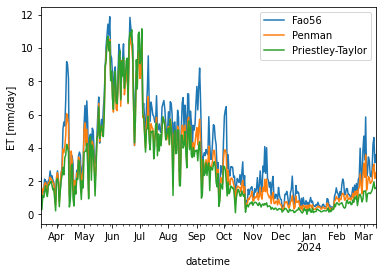

In [23]:
pe_fao56.plot(label="Fao56")
pe_penman.plot(label="Penman");
pe_pt.plot(label="Priestley-Taylor");
plt.ylabel("ET [mm/day] ");
plt.legend();

In [12]:
export_df = pd.DataFrame(data=pe_fao56)
export_df = export_df.reset_index()
export_df['datetime'] = export_df['datetime'].dt.strftime("%m/%d/%Y %H:%M:%S")

export_df['date'] = pd.to_datetime(export_df['datetime'], errors='coerce').dt.date
export_df['time'] = pd.to_datetime(export_df['datetime'], errors='coerce').dt.time
del export_df['datetime']
export_df

,0,date,time
0,2.738537,2024-03-09,00:00:00
1,2.685680,2024-03-10,00:00:00
2,4.202445,2024-03-11,00:00:00
3,4.617034,2024-03-12,00:00:00
4,3.098172,2024-03-13,00:00:00
5,3.566605,2024-03-14,00:00:00


In [13]:
export_df = export_df.rename(columns = {0:'Evap_In'})

In [14]:
cols = list(export_df.columns.values)
order = [1, 2, 0]
reorder_cols = [cols[i] for i in order]

In [17]:
export_df = export_df.loc[:, reorder_cols]
export_df['Evap_In'] = export_df['Evap_In'] / 25.4


,date,time,Evap_In
0,2022-10-21,00:00:00,0.135183
1,2022-10-22,00:00:00,0.153174
2,2022-10-23,00:00:00,0.210596
3,2022-10-24,00:00:00,0.124562
4,2022-10-25,00:00:00,0.078880
5,2022-10-26,00:00:00,0.072807


In [18]:

filename = f"GBD.csv"


In [19]:
export_df.to_csv(filename)